# Importation des bibliothéques utiles pour la suite

In [1]:
import matplotlib.pyplot as plt # Pour l'affichage des graphiques
import numpy as np

# Les modules pour les simulation
import ordinaryMC
import QMC
import MLMC

# Les modules pour les calculs et comparaisons
import calcul
import comparaison

# Importation des valeurs

In [2]:
alpha = 0.15
b = 1
sigma = 0.2
T = 1
r = 0.05
K = 4
k = 20
dt = 1/20
S_0 = 5 #le fixer à 1 si on veut obtenir les cheveux 
nb_samples = 100

# On conserve au maximum 1000, cependant pour certaines parties du projet à cause du temps de calcul max_sample pourra être réduit
max_sample = 1000

# Partie 1 : Monte Carlo Ordinaire

# A) Test du CIR ordinaire

In [3]:
S = ordinaryMC.CIR(alpha, b, sigma, T, k, S_0)
#S1 = CIR.CIR_new(alpha, b, sigma, T/k, T, S_0)

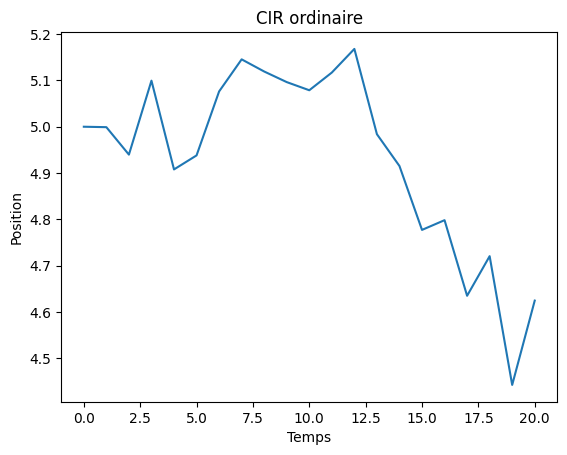

In [4]:
plt.plot(S)
#plt.plot(S1)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR ordinaire')
plt.show()

In [5]:
M = ordinaryMC.multiCIR(alpha, b, sigma, T, k, S_0, nb_samples)

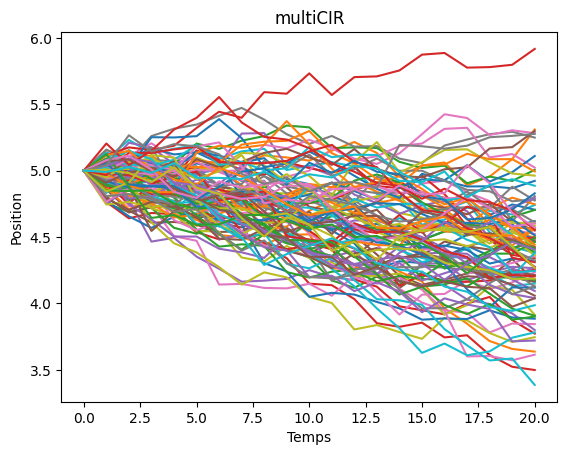

In [6]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

# B) Simulation de Monte Carlo Ordinaire

In [7]:
calcul.pv_calc(M[3],r, T)

array([4.75614712, 4.53220682, 4.41453472, 4.45274055, 4.44421924,
       4.31546787, 4.26408075, 4.29833651, 4.2174313 , 4.12895767,
       3.9465543 , 3.93563902, 3.83634216, 3.66329339, 3.63746846,
       3.66708358, 3.56167913, 3.57674657, 3.43593448, 3.35136206,
       3.32801253])

In [8]:
OMC = ordinaryMC.ordinary_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)

In [9]:
# Première estimation de la valeur C recherchée
np.mean(OMC)

0.7154630773928851

In [10]:
# On estime la valeur C pour différentes tailles d'échantillons de 10 en 10
ordinaryMC_price_esitmates, ordinaryMC_CIs = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method='ordinary')

Price estimated at largest sample size with ordinary MC: 0.6830141439440744
CI length at largest sample size with ordinary MC: 0.027396388429761886


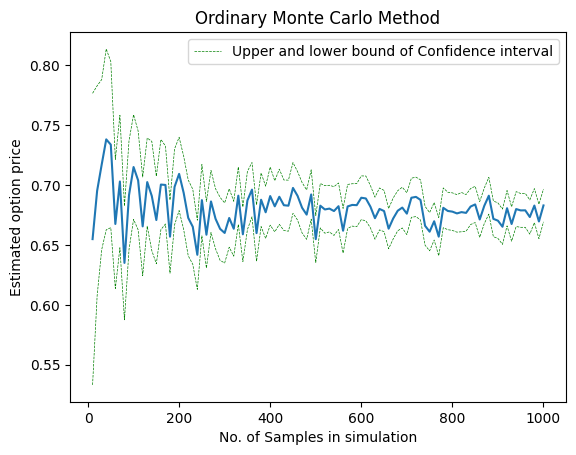

In [11]:
print("Price estimated at largest sample size with ordinary MC:", str(ordinaryMC_price_esitmates[-1]))
print("CI length at largest sample size with ordinary MC:", str(ordinaryMC_CIs[-1,1] - ordinaryMC_CIs[-1,0]))

#Ploting ordinary Monte Carlo method
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinaryMC_price_esitmates)
plt.plot(x_axis1, ordinaryMC_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, ordinaryMC_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()


In [12]:
tol = 0.03
mc_threshold = comparaison.threshold_finder(ordinaryMC_CIs, tol)

85


In [13]:
if isinstance(mc_threshold, int) ==True :
    sample_convergent = mc_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")


Le seuil que nous considérons comme être celui convergeznt sera donc par la suite : 850


# C) Comparaison Monte Carlo ordinaire

En réalité pour des problèmes de temps d'exécution nous allons prendre une simulation pour un nb_sample = 100 000, ce qui aurait prit trop de temps à exécuter de 10 en 10 précédemment

In [14]:
present_payoffs_cvg = ordinaryMC.ordinary_mc_sim(100000,k, S_0, T, r, sigma, K, alpha, b)
mean_pv_payoffs_cvg = np.mean(present_payoffs_cvg)
mean_pv_payoffs_cvg

0.6783287330163925

In [25]:
CPU_sample = comparaison.CPU(sample_convergent,k, S_0, T, r, sigma, K, alpha, b, method='ordinary')
CPU_sample


0.08287079998990521

In [17]:
max_sample_mse = 100
# Nous prenons 100 aussi pour des raisons de temps d'exécution, sinon vous pouvez mettre 1000 pour être cohérent avec le reste du projet
mse_values = comparaison.mse_comparaison(max_sample_mse, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='ordinary')

10
20
30
40
50
60
70
80
90
100


[array([0.00469711, 0.00261444, 0.00164977, 0.00135886, 0.00105267,
        0.0008817 , 0.00065538, 0.0006414 , 0.0005561 , 0.00050534]),
 0.0005053350834519572,
 9]

In [18]:
mse_values[0]

array([0.00469711, 0.00261444, 0.00164977, 0.00135886, 0.00105267,
       0.0008817 , 0.00065538, 0.0006414 , 0.0005561 , 0.00050534])

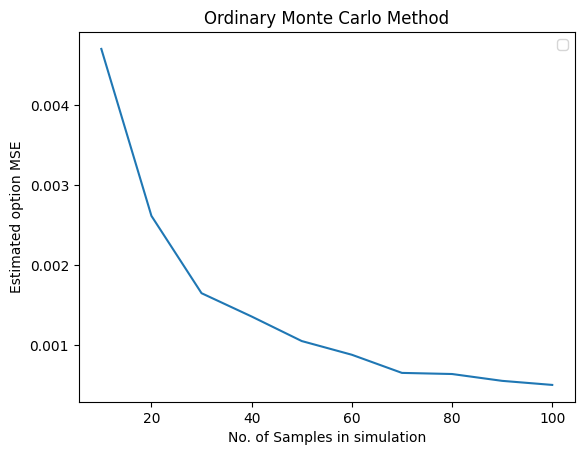

In [20]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values[0])
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option MSE")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()

On obtient bien une courbe décroissante en la valeur des simulations, ce qui est ce qu'on voulait obtenir.

# Partie 2 : Quasi Monte Carlo

# A) Tests Sobol generator et QMC

In [21]:
sobol = QMC.sobol_generator(nb_samples, k)
print(sobol, len(sobol), len(sobol[1,]))

[[0.5     0.75    0.25    ... 0.84375 0.34375 0.46875]
 [0.5     0.25    0.75    ... 0.21875 0.71875 0.09375]
 [0.5     0.75    0.25    ... 0.09375 0.59375 0.46875]
 ...
 [0.75    0.25    0.875   ... 0.53125 0.15625 0.65625]
 [0.75    0.25    0.375   ... 0.09375 0.21875 0.71875]
 [0.75    0.25    0.125   ... 0.78125 0.65625 0.15625]] 117 20


On obtient bien une suite de sobol qui respecte les propriétés recherchées

In [22]:
M = QMC.multiCIR_QMC(alpha, b, sigma, T, k, S_0, nb_samples)

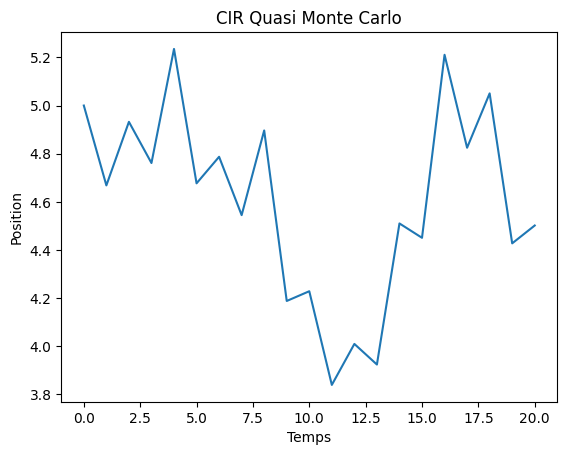

In [23]:
plt.plot(M[1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Quasi Monte Carlo')
plt.show()

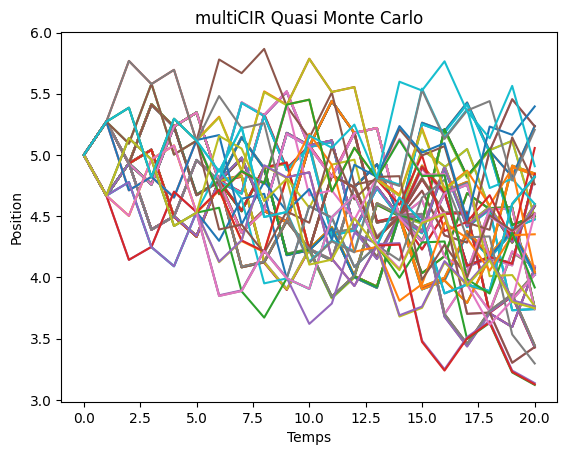

In [24]:
for i in range(nb_samples):
    plt.plot(M[i])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR Quasi Monte Carlo')
plt.show()

In [33]:
calcul.pv_calc(M[3],r, T)

array([4.75614712, 4.44068046, 4.69176034, 4.17766827, 4.28050955,
       4.12694622, 4.55897293, 4.73548607, 4.33053018, 4.92791954,
       4.82997624, 4.86832343, 4.17867483, 4.50821153, 4.27909944,
       4.1584282 , 4.65864569, 4.20561425, 4.34211653, 4.08128781,
       4.36377539])

In [34]:
OMC_QMC = QMC.QMC_mc_sim(nb_samples, k, S_0, T, r, sigma, K, alpha, b)
np.mean(OMC_QMC)

0.6063806656489298

In [25]:
sobol_price_esitmates, sobol_CIs = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method="QMC")

In [47]:
print("Price estimated at largest sample size with Sobol sequence:", str(sobol_price_esitmates[-1]))
print("CI length at largest sample size with Sobol sequence:", str(sobol_CIs[-1,1] - sobol_CIs[-1,0]))

Price estimated at largest sample size with Sobol sequence: 0.6022261570104824
CI length at largest sample size with Sobol sequence: 0.04342628815735039


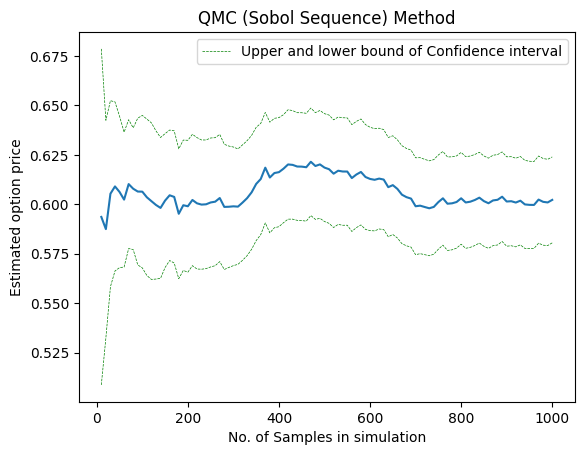

In [49]:
#Ploting quasi-Monte Carlo method using Sobol sequence

plt.plot(x_axis1, sobol_price_esitmates)
plt.plot(x_axis1, sobol_CIs[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol Sequence) Method")
plt.legend()
plt.show()

In [26]:
sobol_threshold = comparaison.threshold_finder(sobol_CIs, tol)

In [27]:
if isinstance(sobol_threshold, int) ==True :
    sample_convergent_QMC = sobol_threshold * 10
    print("Le seuil que nous considérons comme être celui convergeznt sera donc par la suite :",sample_convergent_QMC)
else :
    print("Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand")

Ce threshold n'est jamais atteint: il faut soit prendre un threshold plus grand ou un nombre de simulation maximale plus grand


# B) QMC random

In [52]:
sobol_price_esitmates_random, sobol_CIs_random = calcul.sim_iterator(max_sample, k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')


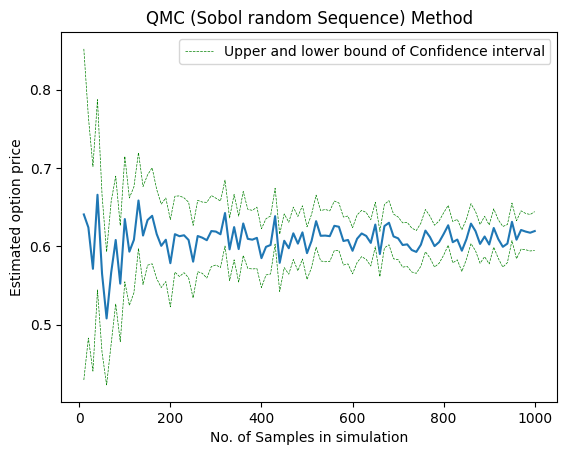

In [53]:
#Ploting quasi-Monte Carlo method using Sobol sequence
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, sobol_price_esitmates_random)
plt.plot(x_axis1, sobol_CIs_random[1:, 0], 'g--', lw=0.5, label='Upper and lower bound of Confidence interval')
plt.plot(x_axis1, sobol_CIs_random[1:, 1], 'g--', lw=0.5)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("QMC (Sobol random Sequence) Method")
plt.legend()
plt.show()

# C) Comparaison QMC randomised

La comparaison est uniquement faites avec le QMC random car elle n'aurait pas de sens avec QMC étant une technique déterministe

In [54]:
mean_pv_payoffs_cvg 
# On garde le même que pour l'ordinaire

0.6786461429088663

In [56]:
CPU_sample_QMC = comparaison.CPU(sample_convergent_QMC,k, S_0, T, r, sigma, K, alpha, b, method='QMC_random')
CPU_sample_QMC

0.12882894999347627

In [60]:
# max_sample_mse = 100
mse_values_QMC = comparaison.mse_comparaison(max_sample_mse, k, S_0, T, r, sigma, K, alpha, b, mean_pv_payoffs_cvg, method='QMC_random')[0]


10
20
30
40
50
60
70
80
90
100


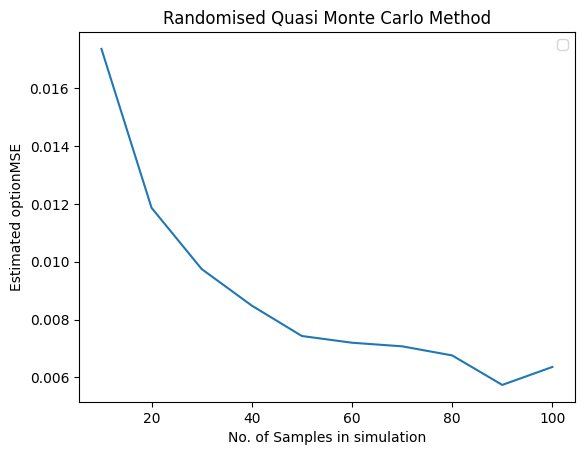

In [62]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values_QMC)
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated optionMSE")
plt.title("Randomised Quasi Monte Carlo Method")
plt.legend()
plt.show()

# Partie 3: Multi Level CIR

In [16]:
import CIR

In [17]:
L = 5

In [18]:
S = CIR.level_CIR(alpha, b, sigma, L, T, S_0)

In [19]:
S

(array([0.     , 0.03125, 0.0625 , 0.09375, 0.125  , 0.15625, 0.1875 ,
        0.21875, 0.25   , 0.28125, 0.3125 , 0.34375, 0.375  , 0.40625,
        0.4375 , 0.46875, 0.5    , 0.53125, 0.5625 , 0.59375, 0.625  ,
        0.65625, 0.6875 , 0.71875, 0.75   , 0.78125, 0.8125 , 0.84375,
        0.875  , 0.90625, 0.9375 , 0.96875, 1.     ]),
 array([5.        , 5.04285382, 5.16734624, 5.07917604, 5.11174178,
        5.09371686, 4.94423893, 4.83891042, 4.78755395, 4.6605593 ,
        4.60964625, 4.52198705, 4.43265387, 4.40241527, 4.39273405,
        4.43660511, 4.37457538, 4.266179  , 4.20694965, 4.20529307,
        4.13874013, 4.11758526, 4.09162349, 4.06648685, 4.06727793,
        4.08837439, 4.07215181, 4.08135939, 4.08147877, 4.13058853,
        4.20635275, 4.14538867, 4.16240109]))

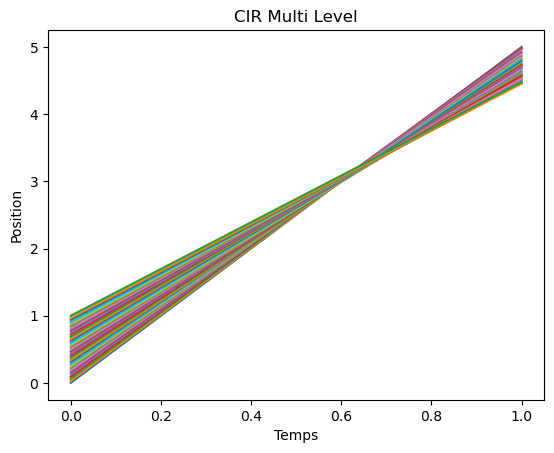

In [ ]:
plt.plot(S)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [ ]:
nb_samples = 100 

In [ ]:
M = CIR.multiCIR_ML_principle(alpha, b, sigma, L, T, S_0)

IndexError: tuple index out of range

In [21]:
multiCIR=[]
M = CIR.CIR_new(alpha, b, sigma, 1/100, T, S_0)
multiCIR.append(M)


In [30]:
for j in range(3): 
    A = ([multiCIR[j][0][i] for i in range(0,len(multiCIR[j][0])+1,2)],[multiCIR[j][1][i] for i in range(0,len(multiCIR[j][0])+1,2)])
    multiCIR.append(A)

In [31]:
multiCIR

[(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
         0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
         0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
         0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
         0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
         0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
         0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
         0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
         0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
         0.99, 1.  ]),
  array([5.        , 4.99536775, 4.99231617, 4.93821779, 4.92060888,
         4.99065811, 4.98733267, 4.92598168, 4.97855978, 4.81827023,
         4.7961825 , 4.87447551, 4.87337389, 4.80883166, 4.78883919,
         4.7813592 , 4.83042374, 4.83145046, 4.80112199, 4.88503659,
         4.8374862 , 4.821

In [20]:
for i in range(10):
    plt.plot(multiCIR[i][0],multiCIR[i][1])
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('multiCIR')
plt.show()

NameError: name 'multiCIR' is not defined

In [ ]:
zap = CIR.CIR(alpha, b, sigma, T, k, S_0)
zap2 = CIR.CIR_ML(alpha, b, sigma, T, k, S_0,5)

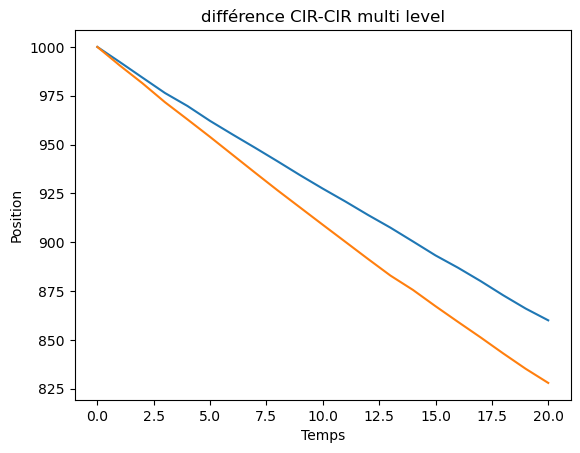

In [ ]:
plt.plot(zap)
plt.plot(zap2)
plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('différence CIR-CIR multi level')
plt.show()

# Multi Level Monte Carlo

In [3]:
import MLMC

In [4]:
import CIR

Le ordinary tu fais n fois avec la même dicrétisation alors que le multi level tu fais n fois mais avec des discrétisations de plus en plus fines. Et en plus c'est "gratuit" car on utilise le même mouvement brownien.

In [5]:
test=CIR.multiCIR_ML(alpha, b, sigma, 3, T, S_0, 3)

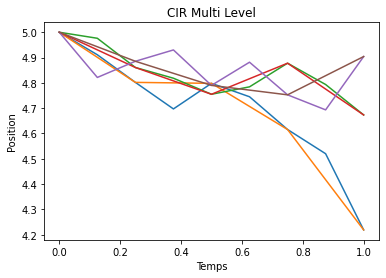

In [6]:
for i in range(3): #nb_sample
    plt.plot(test[i][0][0],test[i][0][1])
    plt.plot(test[i][1][0],test[i][1][1])


plt.xlabel('Temps')
plt.ylabel('Position')
plt.title('CIR Multi Level')
plt.show()

In [4]:
MLMC.sim_MLMC(k, S_0, T, r, sigma, K, alpha, b) #return y_chap, L, N, variances, means

(0.6621064065727643,
 4,
 [91715, 42443, 32400, 18061, 10355],
 array([0.04529601, 0.00523407, 0.00201053, 0.00064552, 0.0001964 ]),
 array([ 0.66645134, -0.00269981, -0.00156139, -0.00080113,  0.00071739]))

# Partie 4 : Comparaison et conclusion pour tous les modèles

# A) Intervalles de confiance

In [63]:
ordinary_CI_lengths = comparaison.CI_length_calc(ordinaryMC_CIs)
sobol_CI_lengths = comparaison.CI_length_calc(sobol_CIs)
sobol_CI_lengths_random = comparaison.CI_length_calc(sobol_CIs_random)

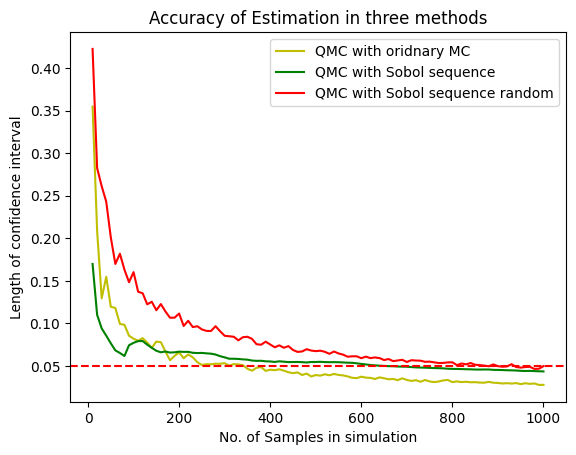

In [65]:
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, ordinary_CI_lengths, 'y', label="QMC with oridnary MC")
plt.plot(x_axis1, sobol_CI_lengths, 'g', label="QMC with Sobol sequence")
plt.plot(x_axis1,sobol_CI_lengths_random, 'r', label="QMC with Sobol sequence random")


tol = 0.05
plt.axhline(tol, ls='--', c='r')
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Length of confidence interval")
plt.title("Accuracy of Estimation in three methods")
plt.legend()
plt.show()

# B) CPU Time

In [66]:
print("Le CPU Time de ordinary est :", CPU_sample)
print("Le CPU Time du quasi monte carlo randomised est :", CPU_sample_QMC)

Le CPU Time de ordinary est : 0.08287079998990521
Le CPU Time du quasi monte carlo randomised est : 0.12882894999347627


# C) MSE

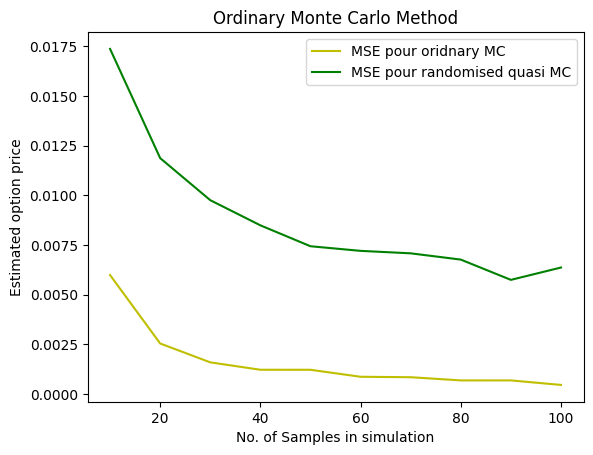

In [67]:
x_axis1 = range(10, max_sample_mse + 1, 10)
plt.plot(x_axis1, mse_values, 'y', label="MSE pour oridnary MC")
plt.plot(x_axis1, mse_values_QMC, 'g', label="MSE pour randomised quasi MC")
plt.xlabel("No. of Samples in simulation")
plt.ylabel("Estimated option price")
plt.title("Ordinary Monte Carlo Method")
plt.legend()
plt.show()